## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

In [1]:
# Включаем проверку PEP8
#%load_ext pycodestyle_magic
#%pycodestyle_on

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [3]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [4]:
# Переводим признак pickup_datetime
# в тип данных datetime заданного формата
taxi_data['pickup_datetime'] = pd.to_datetime(
    taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

# Определяем временные рамки (без учета времени),
# за которые представлены данные.
start_date = taxi_data['pickup_datetime'].dt.date.min()
end_date = taxi_data['pickup_datetime'].dt.date.max()

# Выводим начало и окончание временных рамок
print('Начало:    {}'.format(start_date))
print('Окончание: {}'.format(end_date))

Начало:    2016-01-01
Окончание: 2016-06-30


### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [5]:
# Подсчитываем общее количество пропущенных значений в данных:
# isna() создаёт булеву матрицу, где True - пропуск,
# sum() применяется дважды, сначала к столбцам, затем к полученным суммам.
print('Пропущено {} значений'.
      format(taxi_data.isna().sum().sum()))

Пропущено 0 значений


### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [6]:
# а) Считаем кол-во уникальных таксопарков
# с помощью метода nunique()
print('а) Уникальных таксопарков: {}'.
      format(taxi_data['vendor_id'].nunique()))

а) Уникальных таксопарков: 2


In [7]:
# Считаем максимальное кол-во пассажиров
# с помощью метода max()
print('б) Максимальное количество пассажиров: {}'.
      format(taxi_data['passenger_count'].max()))

б) Максимальное количество пассажиров: 9


In [8]:
# Считаем длительность поездки в секундах и округляем
# до целого. Получаем среднюю и медианную длительности
# с помощью методов mean(), median()
print('в) Средняя длительность поездки:   {} сек'.
      format(round(taxi_data['trip_duration'].mean())))
print('   Медианная длительность поездки: {} сек'.
      format(round(taxi_data['trip_duration'].median())))

в) Средняя длительность поездки:   959 сек
   Медианная длительность поездки: 662 сек


In [9]:
# Считаем минимальное и максимальное время
# с помощью методов min(), max()
print('г) Минимальное время поездки:  {} сек'.
      format(taxi_data['trip_duration'].min()))
print('   Максимальное время поездки: {} сек'.
      format(taxi_data['trip_duration'].max()))

г) Минимальное время поездки:  1 сек
   Максимальное время поездки: 3526282 сек


**В данных присутствуют поездки, продолжительность которых составляет одну секунду, а также поездки, продолжительность которых больше 40 дней. Следовательно, это выбросы.**

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [10]:
# Переводим признак pickup_datetime в тип данных datetime.
# Добавляем новые столбцы pickup_date, pickup_hour,
# pickup_day_of_week, используя методы dt.date,
# dt.hour, dt.dayofweek
def add_datetime_features(taxi_data):
    taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'],
                                                  format='%Y-%m-%d %H:%M:%S')
    taxi_data['pickup_date'] = taxi_data['pickup_datetime'].dt.date
    taxi_data['pickup_hour'] = taxi_data['pickup_datetime'].dt.hour
    taxi_data['pickup_day_of_week'] = taxi_data['pickup_datetime'].dt.dayofweek
    return taxi_data


# Обновляем датафрейм с помощью функции add_datetime_features()
taxi_data = add_datetime_features(taxi_data)

In [11]:
# Считаем кол-во поездок в субботу (день 5)
print('а) Поездок в субботу: {}'.
      format(len(taxi_data[taxi_data['pickup_day_of_week'] == 5])))

# Группируем данные по столбцу pickup_date с помощью функции groupby(),
# применяем метод count() для подсчёта числа поездок в каждой группе.
# Вычисляем среднее значение с помощью метода mean()
print('б) Поездок в среднем за день: {}'.
      format(round(taxi_data.groupby('pickup_date').count()['id'].mean())))

а) Поездок в субботу: 220868
б) Поездок в среднем за день: 8015


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [12]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')


# Добавляем столбец pickup_holiday с данными о поездках в праздники
def add_holiday_features(taxi_data, holiday_data):
    taxi_data['pickup_holiday'] = taxi_data['pickup_date'].apply(
        lambda x: 1 if str(x) in holiday_data['date'].values else 0)
    return taxi_data


# Обновляем датафрейм с помощью функции add_holiday_features()
taxi_data = add_holiday_features(taxi_data, holiday_data)

# Считаем медианную длительность поездки на такси в праздничные дни
trip_duration_holiday_median = round(taxi_data.loc
        [taxi_data['pickup_holiday'] == 1, 'trip_duration'].median())

print('Медианная длительность поездки на такси в праздничные дни: {} сек'.
      format(trip_duration_holiday_median))

Медианная длительность поездки на такси в праздничные дни: 585 сек


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [13]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')

# Добавляем столбцы total_distance, total_travel_time,
# number_of_steps с данными из OSRM
def add_osrm_features(taxi_data, osrm_data):
    osrm = osrm_data[['id', 'total_distance',
                      'total_travel_time', 'number_of_steps']]
    taxi_data = pd.merge(taxi_data, osrm, on='id', how='left')
    return taxi_data


# Обновляем датафрейм с помощью функции add_osrm_features()
taxi_data = add_osrm_features(taxi_data, osrm_data)

In [14]:
# Считаем разницу между медианными
# длительностями поездок в данных и из OSRM
duration_difference_rounded = round(taxi_data['trip_duration'].
    median() - osrm_data['total_travel_time'].median())

# Считаем кол-во пропусков в столбцах данных из OSRM
columns_nan = taxi_data.isnull().sum()
columns_nan = columns_nan[columns_nan > 0]

# Выводим результаты
print('а) Разница медианных длительностей поездки данных и OSRM: {} сек'.
      format(duration_difference_rounded))
print('б) Пропусков в столбцах: \n{}'.format(columns_nan))

а) Разница медианных длительностей поездки данных и OSRM: 372 сек
б) Пропусков в столбцах: 
total_distance       1
total_travel_time    1
number_of_steps      1
dtype: int64


In [15]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [16]:
# Добавляем столбцы haversine_distance,
# direction с данными о расстоянии Хаверсина
def add_geographical_features(taxi_data):
    taxi_data['haversine_distance'] = get_haversine_distance(
        lat1=taxi_data['pickup_latitude'],
        lng1=taxi_data['pickup_longitude'],
        lat2=taxi_data['dropoff_latitude'],
        lng2=taxi_data['dropoff_longitude'])
    taxi_data['direction'] = get_angle_direction(
        lat1=taxi_data['pickup_latitude'],
        lng1=taxi_data['pickup_longitude'],
        lat2=taxi_data['dropoff_latitude'],
        lng2=taxi_data['dropoff_longitude'])
    return taxi_data


# Обновляем датафрейм с помощью функции add_geographical_features()
taxi_data = add_geographical_features(taxi_data)

In [17]:
# Считаем медианное расстояние Хаверсина
print('Медианное расстояние Хаверсина: {} км'.
      format(round(taxi_data['haversine_distance'].median(), 2)))

Медианное расстояние Хаверсина: 2.09 км


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [18]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

KMeans(n_clusters=10, random_state=42)

In [19]:
# Добавляем столбец geo_cluster - географический кластер,
# к которому относится поездка
def add_cluster_features(taxi_data, kmeans):
    taxi_data['geo_cluster'] = kmeans.predict(
        taxi_data[['pickup_latitude', 'pickup_longitude',
                   'dropoff_latitude', 'dropoff_longitude']])
    return taxi_data


# Обновляем датафрейм с помощью функции add_cluster_features()
taxi_data = add_cluster_features(taxi_data, kmeans)

c:\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [20]:
# Считаем кол-во поездок в наименьшем географическом кластере
print('Поездок в наименьшем географическом кластере: {}'.
      format(taxi_data.groupby('geo_cluster').size().min()))

Поездок в наименьшем географическом кластере: 2


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [21]:
weather_data = pd.read_csv('data/weather_data.csv')

# Добавляем столбцы с данными о погоде из weather_data
def add_weather_features(taxi_data, weather_data):
    # Переводим признак time в тип данных datetime заданного формата
    weather_data['time'] = pd.to_datetime(weather_data['time'],
                                          format='%Y-%m-%d %H:%M:%S')
    # Извлекаем дату и час из столбца time в weather_data
    weather_data['date'] = weather_data['time'].dt.date
    weather_data['hour'] = weather_data['time'].dt.hour
    weather_data = weather_data[['temperature', 'visibility', 'wind speed',
                                 'precip', 'events', 'date', 'hour']]
    # Объединяем датафреймы taxi_data и weather_data
    taxi_data = taxi_data.merge(weather_data,
        left_on=['pickup_date', 'pickup_hour'],
        right_on=['date', 'hour'], how='left')
    # Удаляем столбцы date и hour
    taxi_data = taxi_data.drop(['date', 'hour'], axis=1)
    return taxi_data


# Обновляем датафрейм с помощью функции add_weather_features()
taxi_data = add_weather_features(taxi_data, weather_data)

In [22]:
# Считаем кол-во поездок в снежную погоду
print('а) Поездок в снежную погоду: {}'.
      format(len(taxi_data[taxi_data['events'] == 'Snow'])))

# Выделяем все столбцы с погодными условиями
weather_columns = ['temperature', 'visibility',
                   'wind speed', 'precip', 'events']

# Считаем % пропусков в столбцах с погодными условиями
columns_nan_perc = taxi_data[weather_columns].isnull().mean() * 100
columns_nan_weather = columns_nan_perc[columns_nan_perc > 0]. \
    sort_values(ascending = False)

# Выводим результаты
print('б) Пропусков в столбцах с погодными условиями:\n',
      format(round(columns_nan_weather, 2)))

а) Поездок в снежную погоду: 13126
б) Пропусков в столбцах с погодными условиями:
 temperature    0.82
visibility     0.82
wind speed     0.82
precip         0.82
events         0.82
dtype: float64


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [23]:
# Заполняем пропуски в столбцах с погодными условиями медианным
# значением температуры, влажности, скорости ветра и видимости
# в зависимости от даты начала поездки
def fill_null_weather_data(taxi_data):
    weather_columns = ['temperature', 'visibility', 'wind speed', 'precip']
    
    for col in weather_columns:
        taxi_data[col] = taxi_data[col].fillna(
            taxi_data.groupby('pickup_date')[col].transform('median'))

    taxi_data['events'] = taxi_data['events'].fillna('None')
    osrm_columns = ['total_distance', 'total_travel_time', 'number_of_steps']
    taxi_data[osrm_columns] = taxi_data[osrm_columns].fillna(
        taxi_data[osrm_columns].median())
    return taxi_data


# Обновляем датафрейм с помощью функции fill_null_weather_data()
taxi_data = fill_null_weather_data(taxi_data)

In [24]:
# Выводим результаты
print('Медиана в столбце "temperature" после заполнения пропусков: {}'.
      format(round(taxi_data['temperature'].median(), 1)))

Медиана в столбце "temperature" после заполнения пропусков: 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


Text(0, 0.5, 'Average speed')

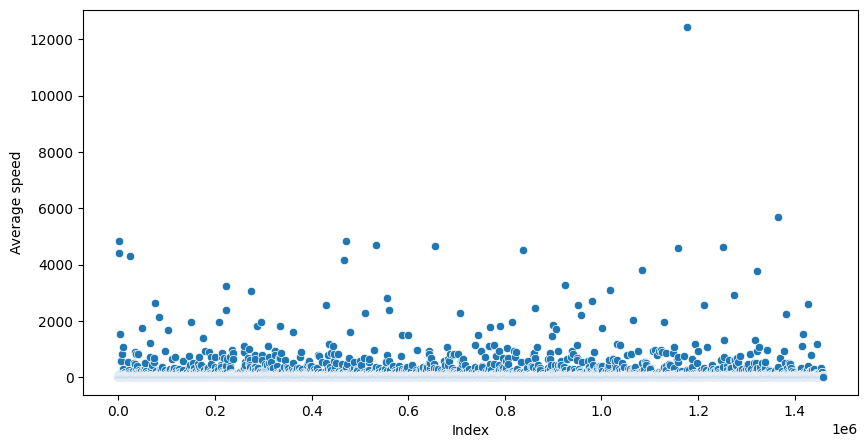

In [25]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed')

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [26]:
# Считаем кол-во выбросов по признаку длительности поездки
print('а) Выбросов по признаку длительности поездки: {}'.
      format(taxi_data[taxi_data['trip_duration'] > 24*60*60].shape[0]))

# Считаем кол-во выбросов по признаку скорости свыше 300 км/ч
print('б) Выбросов по признаку скорости: {}'.
      format(avg_speed[avg_speed > 300].shape[0]))

# Удаляем эти выбросы
taxi_data = taxi_data[(taxi_data['trip_duration'] <= 24 * 60 * 60)
      & (taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6 <= 300)]

а) Выбросов по признаку длительности поездки: 4
б) Выбросов по признаку скорости: 407


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [27]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

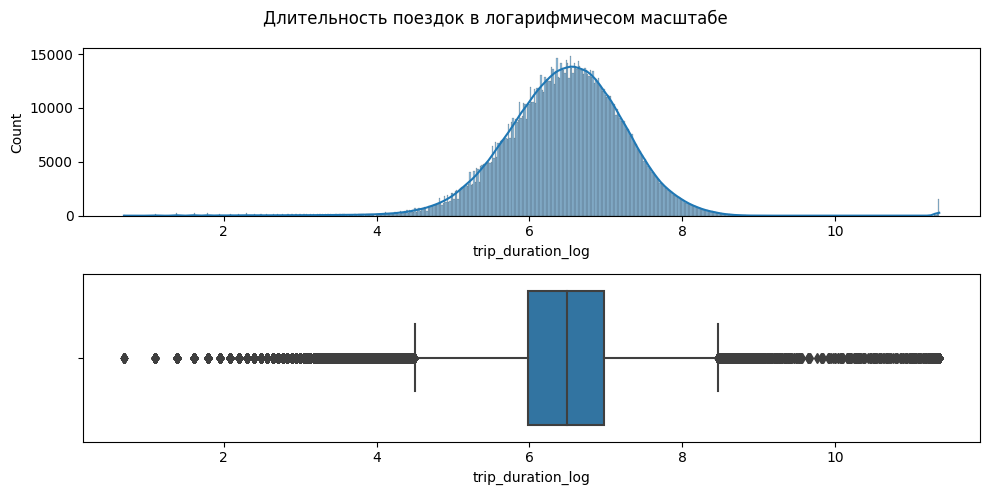

In [28]:
# Строим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
fig.suptitle('Длительность поездок в логарифмичесом масштабе')
sns.histplot(data=taxi_data, x='trip_duration_log', kde=True, ax=ax[0])
sns.boxplot(data=taxi_data, x='trip_duration_log', ax=ax[1])
plt.tight_layout()
plt.show()

In [29]:
# Проверяем гипотезу о нормальности полученного распределения
# с помощью теста Д’Агостино
_, p_value = stats.normaltest(taxi_data['trip_duration_log'])

# Считаем и выводим P-value
print('а) P-value: {}'.format(round(p_value, 2)))

# Сравниваем P-value с уровнем значимости 0.05
if p_value > 0.05 / 2:
    print('б) Распределение является нормальным')
else:
    print('б) Распределение не является нормальным')

а) P-value: 0.0
б) Распределение не является нормальным


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

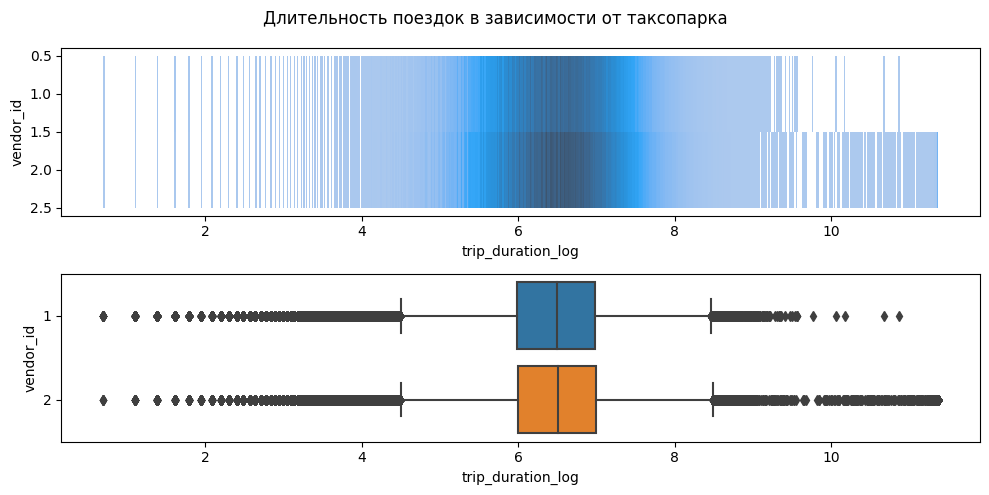

In [30]:
# Преобразуем vendor_id в тип category
taxi_data['vendor_id'] = taxi_data['vendor_id'].astype('category')

# Строим гистограмму и коробчатую диаграмму
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
fig.suptitle('Длительность поездок в зависимости от таксопарка')
sns.histplot(data=taxi_data, x='trip_duration_log', y='vendor_id', ax=ax[0])
sns.boxplot(data=taxi_data, x='trip_duration_log', y='vendor_id', ax=ax[1])
plt.tight_layout()
plt.show()

**Распределения в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки.**

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

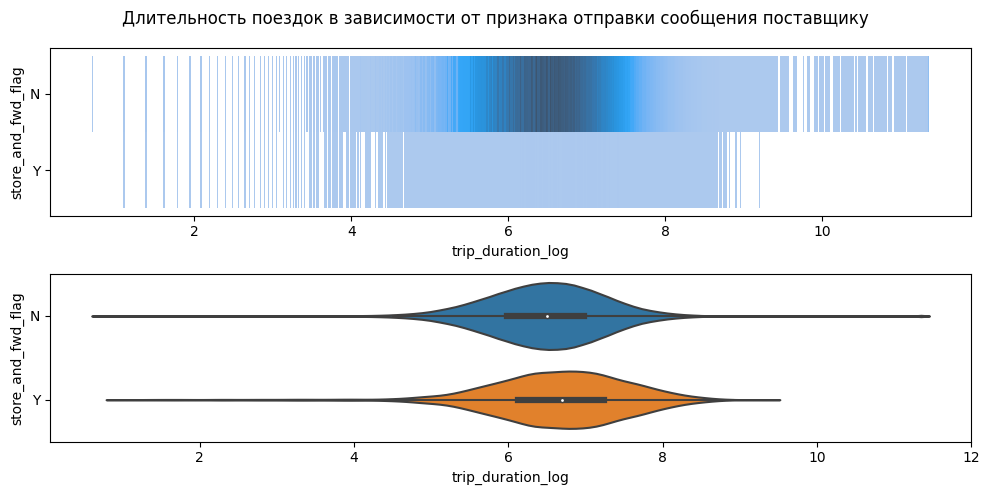

In [31]:
# Строим гистограмму и скрипичный график
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
fig.suptitle('Длительность поездок в зависимости \
от признака отправки сообщения поставщику')
sns.histplot(data=taxi_data, x='trip_duration_log',
             y='store_and_fwd_flag', ax=ax[0])
sns.violinplot(data=taxi_data, x='trip_duration_log',
            y='store_and_fwd_flag', ax=ax[1])
plt.tight_layout()
plt.show()

**Распределения в группах значительно отличаются, признак store_and_fwd_flag имеет значение при определении длительности поездки.**

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

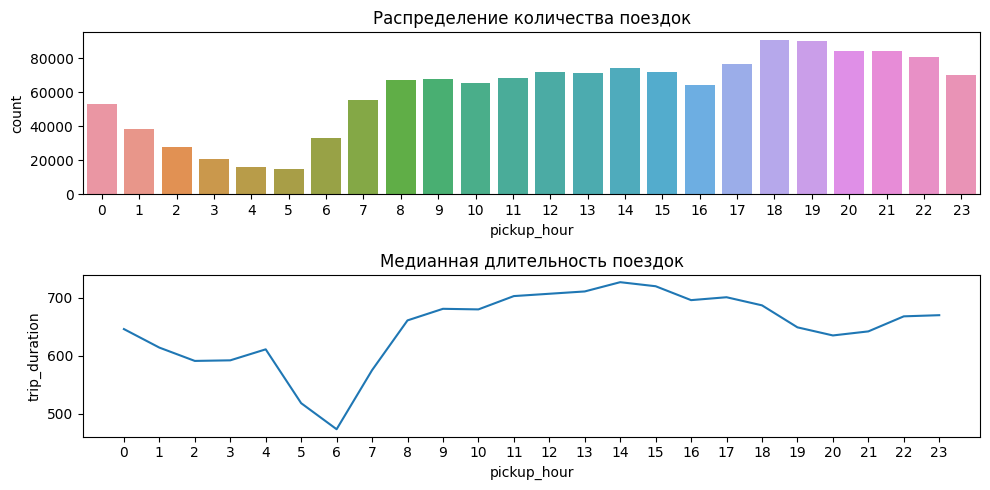

In [32]:
# Считаем медианную продолжительность поездок по часам
duration_hour = taxi_data.groupby('pickup_hour')['trip_duration'].median()

# Строим столбчатую диаграмму и линейный график
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
sns.countplot(data=taxi_data, x='pickup_hour', ax=ax[0])
ax[0].set_title('Распределение количества поездок')
sns.lineplot(data=duration_hour, ax=ax[1])
ax[1].xaxis.set_ticks(duration_hour.index)
ax[1].set_title('Медианная длительность поездок')
plt.tight_layout()
plt.show()

**Следовательно:**

**а) Реже всего такси заказывают с 00:00 по 5:00**

**б) Пик медианной длительности поездок с 13:00 по 18:00**

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


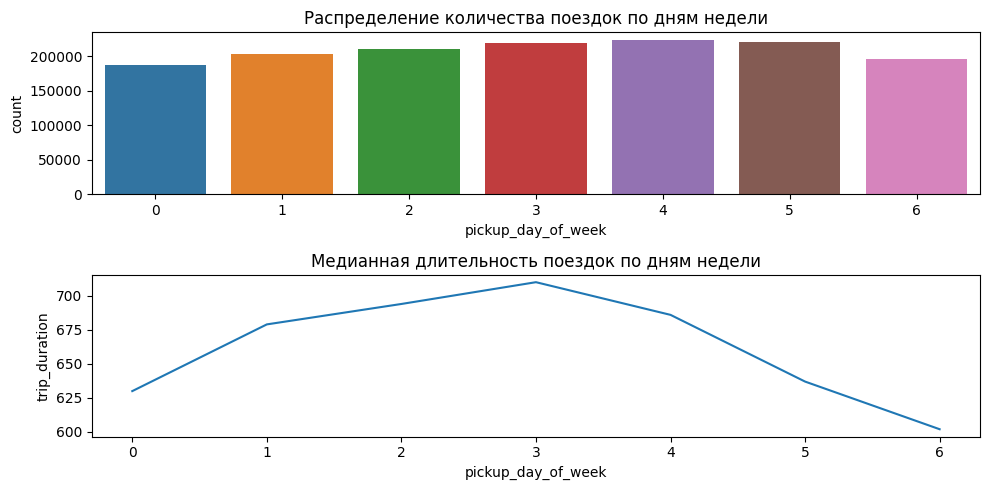

In [33]:
# Группируем данные по дню недели и считаем медианную длительность поездок
duration_day = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median()

# Строим столбчатую диаграмму и линейный график
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
sns.countplot(data=taxi_data, x='pickup_day_of_week', ax=ax[0])
ax[0].set_title('Распределение количества поездок по дням недели')
sns.lineplot(data=duration_day, ax=ax[1])
ax[1].xaxis.set_ticks(duration_day.index)
ax[1].set_title('Медианная длительность поездок по дням недели')
plt.tight_layout()
plt.show()

**Следовательно:**

**а) Больше всего поездок совершается в пятницу (Friday)**

**б) Медианная длительность поездок наименьшая в воскресенье (Sunday)**

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

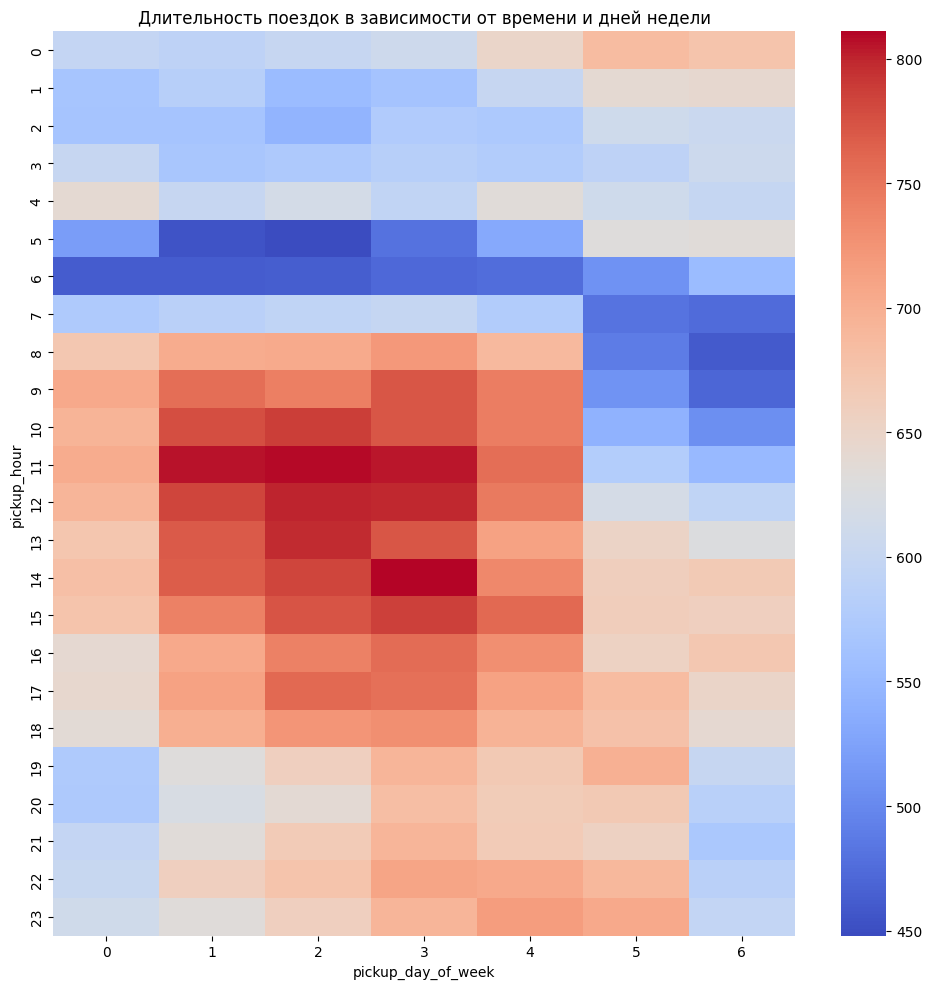

In [34]:
# Строим сводную таблицу медианной длительности поездок
# в зависимости от часов и дней недели
pivot = taxi_data.pivot_table(values='trip_duration',
    index='pickup_hour', columns='pickup_day_of_week', aggfunc='median')

# Строим тепловую карту
fig = plt.figure(figsize=(10, 10))
ax = sns.heatmap(data=pivot, cmap='coolwarm')
ax.set_title('Длительность поездок в зависимости от времени и дней недели')
plt.tight_layout()
plt.show()

**Следовательно:**

**а) Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 8 до 18 часов.**

**б) Наибольшая медианная длительность поездки наблюдалась в четверг в 14 часов дня.**

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


C:\Users\diana\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


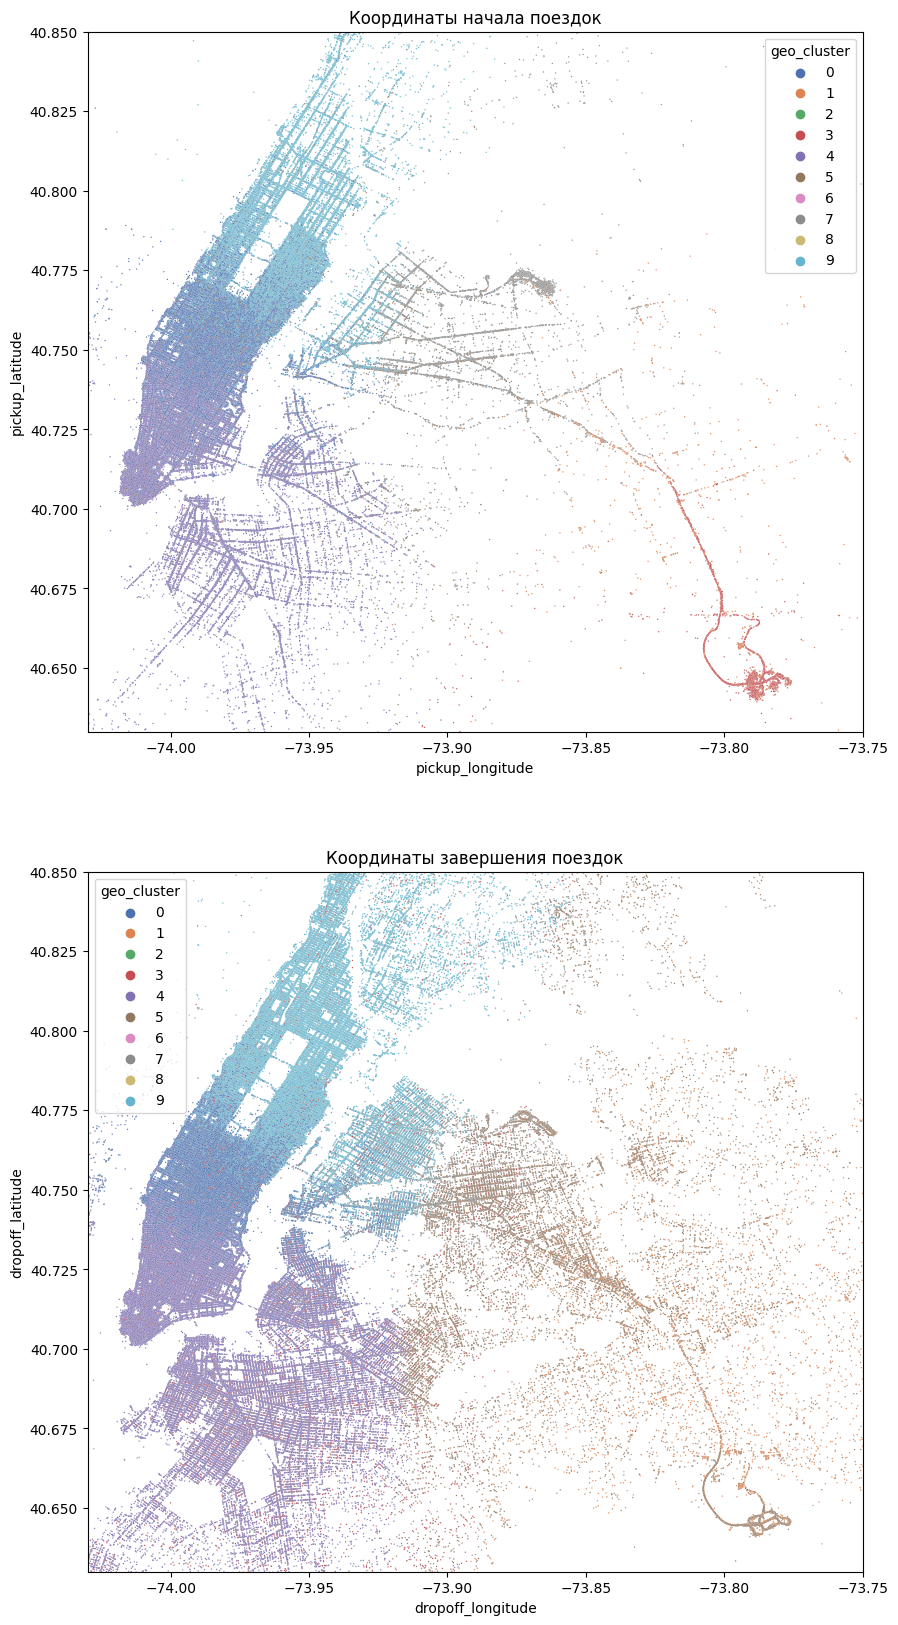

In [35]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Строим диаграммы рассеяния координат начала и завершения поездок
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
sns.scatterplot(data=taxi_data, x='pickup_longitude',
                y='pickup_latitude', hue='geo_cluster',
                s=1, ax=ax[0], palette='deep')
ax[0].set_title('Координаты начала поездок')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
sns.scatterplot(data=taxi_data, x='dropoff_longitude',
                y='dropoff_latitude', hue='geo_cluster',
                s=1, ax=ax[1], palette='deep')
ax[1].set_title('Координаты завершения поездок')
ax[1].set_xlim(city_long_border)
ax[1].set_ylim(city_lat_border)
plt.show()

**2 из десяти кластеров не попали на диаграммы (находится за границами Нью-Йорка)**

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [36]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [37]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


**Ответы:**

а) Уникальным для каждой поездки является её идентификатор — столбец id. Он никак не связан с длительностью поездки и не имеет значения при её прогнозировании.

б) Утечка данных (data leak) - это ситуация, в которой данные используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной, но эти данные недоступны в реальных условиях.

в) Наличие признака dropoff_datetime (время остановки счётчика) в обучающем наборе данных создаёт утечку данных.

In [38]:
# Удаляем столбцы id и dropoff_time из исходной таблицы с данными
train_data = train_data.drop(['id', 'dropoff_datetime'], axis=1)
print('г) В таблице осталось {} столбцов'.format(train_data.shape[1]))

г) В таблице осталось 25 столбцов


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [39]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [40]:
# Кодируем признаки vendor_id и store_and_fwd_flag
train_data['vendor_id'] = train_data['vendor_id'].apply(
    lambda x: 0 if x == 1 else 1).astype('int')
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(
    lambda x: 0 if x == 'N' else 1)

In [41]:
# Выводим результаты
print('а) Среднее по закодированному столбцу vendor_id: {}'.
      format(round(train_data['vendor_id'].mean(), 2)))
print('б) Среднее по закодированному столбцу store_and_fwd_flag: {}'.
      format(round(train_data['store_and_fwd_flag'].mean(), 3)))

а) Среднее по закодированному столбцу vendor_id: 0.53
б) Среднее по закодированному столбцу store_and_fwd_flag: 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [42]:
# Импортируем класс OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

# Выбираем столбцы для кодирования
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

# Создаём экземпляр класса OneHotEncoder
one_hot_encoder = OneHotEncoder(drop='first')

# Применяем к выбранным столбцам OneHotEncoder
data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change])

# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()

# Создаём датафрейм из закодированных признаков
data_onehot = pd.DataFrame(data_onehot.toarray(), columns=column_names)

In [43]:
# Выводим результат
print('Сгенерировано бинарных столбцов: {}'.
      format(data_onehot.shape[1]))

Сгенерировано бинарных столбцов: 18


Добавим полученную таблицу с закодированными признаками:

In [44]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [45]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [46]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [47]:
# Импортируем класс SelectKBest и f_regression
from sklearn.feature_selection import SelectKBest, f_regression

# Создаём объект класса SelectKBest с 25 признаками
k_best = SelectKBest(score_func=f_regression, k=25)

# Отбираем признаки по тренировочной выборке
k_best.fit_transform(X_train, y_train_log)

# Получаем индексы отобранных признаков
best_features = k_best.get_feature_names_out()
X_train = X_train[best_features]
X_valid = X_valid[best_features]

In [48]:
# Выводим результат
print('Отобранные признаки:\n{}'.format(best_features))

Отобранные признаки:
['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'pickup_holiday' 'total_distance' 'total_travel_time' 'number_of_steps'
 'haversine_distance' 'temperature' 'pickup_day_of_week_1'
 'pickup_day_of_week_2' 'pickup_day_of_week_3' 'pickup_day_of_week_4'
 'pickup_day_of_week_5' 'pickup_day_of_week_6' 'geo_cluster_1'
 'geo_cluster_3' 'geo_cluster_5' 'geo_cluster_7' 'geo_cluster_9']


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [49]:
# Импортируем класс MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Создаём объект класса MinMaxScaler
scaler = MinMaxScaler()

# Масштабируем значения признаков тренировочной выборки
X_train = scaler.fit_transform(X_train)

# Масштабируем значения признаков валидационной выборки
X_valid = scaler.transform(X_valid)

In [50]:
# Выводим результат
print('Среднее арифметическое для первого предиктора: {}'.
      format(round(X_valid[:, 0].mean(), 2)))

Среднее арифметическое для первого предиктора: 0.54


In [51]:
# Переводим X_train и X_valid из массива в датафреймы
X_train = pd.DataFrame(X_train, columns=best_features)
X_valid = pd.DataFrame(X_valid, columns=best_features)

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [52]:
# Импортируем класс LinearRegression
from sklearn.linear_model import LinearRegression

# Создаём модель-объект класса LinearRegression
linear_model = LinearRegression()

# Обучаем модель на тренировочной выборке
linear_model.fit(X_train, y_train_log)

# Предсказываем значения на тренировочной выборке
y_train_pred = linear_model.predict(X_train)

# Предсказываем значения на валидационной выборке
y_valid_pred = linear_model.predict(X_valid)

In [53]:
# Считаем метрику RMSLE на тренировочной выборке
print('RMSLE на тренировочной выборке: {}'.
      format(round(np.sqrt(metrics.
            mean_squared_error(y_train_log, y_train_pred)), 2)))

# Считаем метрику RMSLE на валидационной выборке
print('RMSLE на валидационной выборке: {}'.
      format(round(np.sqrt(metrics.
            mean_squared_error(y_valid_log, y_valid_pred)), 2)))

RMSLE на тренировочной выборке: 0.54
RMSLE на валидационной выборке: 0.54


**Т.к. метрики RMSLE на тренировочной и валидационной выборках сопоставимы, то проблема переобучения модели отсутствует.**

### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [54]:
# Импортируем класс PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures

# Создаём объект класса PolynomialFeatures 2-ой степени
poly_features = PolynomialFeatures(degree=2, include_bias=False)

# Обучаем его на тренировочной выборке
poly_features.fit(X_train)

# Генерируем полиномиальные признаки на тренировочной выборке
X_train_poly = poly_features.transform(X_train)

# Генерируем полиномиальные признаки на валидационной выборке
X_valid_poly = poly_features.transform(X_valid)

# Создаём модель-объект класса LinearRegression
poly_model = LinearRegression()

# Обучаем модель на тренировочной выборке
poly_model.fit(X_train_poly, y_train_log)

# Предсказываем значения на тренировочной выборке
y_train_pred = poly_model.predict(X_train_poly)

# Предсказываем значения на валидационной выборке
y_valid_pred = poly_model.predict(X_valid_poly)

In [55]:
# Считаем метрику RMSLE на тренировочной выборке
print('а) RMSLE на тренировочной выборке: {}'.
      format(round(np.sqrt(metrics.
            mean_squared_error(y_train_log, y_train_pred)), 2)))

# Считаем метрику RMSLE на валидационной выборке
print('   RMSLE на валидационной выборке: {}'.
      format(round(np.sqrt(metrics.
            mean_squared_error(y_valid_log, y_valid_pred)), 2)))

а) RMSLE на тренировочной выборке: 0.47
   RMSLE на валидационной выборке: 0.7


**б) У модели наблюдаются признаки переобучения.**

### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [56]:
# Импортируем класс Ridge
from sklearn.linear_model import Ridge

# Создаём модель-объект класса Ridge с КР = 1
ridge_model = Ridge(alpha=1)

# Обучаем модель на тренировочной выборке
ridge_model.fit(X_train_poly, y_train_log)

# Предсказываем значения на тренировочной выборке
y_train_pred = ridge_model.predict(X_train_poly)

# Предсказываем значения на валидационной выборке
y_valid_pred = ridge_model.predict(X_valid_poly)

In [57]:
# Считаем метрику RMSLE на тренировочной выборке
print('RMSLE на тренировочной выборке: {}'.
      format(round(np.sqrt(metrics.
            mean_squared_error(y_train_log, y_train_pred)), 2)))

# Считаем метрику RMSLE на валидационной выборке
print('RMSLE на валидационной выборке: {}'.
      format(round(np.sqrt(metrics.
            mean_squared_error(y_valid_log, y_valid_pred)), 2)))

RMSLE на тренировочной выборке: 0.48
RMSLE на валидационной выборке: 0.48


**Т.к. метрики RMSLE на тренировочной и валидационной выборках сопоставимы, то проблема переобучения модели отсутствует.**

### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [58]:
# Импортируем класс DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

# Создаём модель-объект класса DecisionTreeRegressor
tree_model = DecisionTreeRegressor(random_state=42)

# Обучаем модель на тренировочной выборке
tree_model.fit(X_train, y_train_log)

# Предсказываем значения на тренировочной выборке
y_train_pred = tree_model.predict(X_train)

# Предсказываем значения на валидационной выборке
y_valid_pred = tree_model.predict(X_valid)

In [59]:
# Считаем метрику RMSLE на тренировочной выборке
print('а) RMSLE на тренировочной выборке: {}'.
      format(round(np.sqrt(metrics.
            mean_squared_error(y_train_log, y_train_pred)), 2)))

# Считаем метрику RMSLE на валидационной выборке
print('   RMSLE на валидационной выборке: {}'.
      format(round(np.sqrt(metrics.
            mean_squared_error(y_valid_log, y_valid_pred)), 2)))

а) RMSLE на тренировочной выборке: 0.0
   RMSLE на валидационной выборке: 0.57


**б) У модели наблюдаются признаки переобучения.**

### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [60]:
# Cоздаём список всех возможных вариантов от 7 до 20
max_depths = range(7, 20)

# Создаём пустые списки, в которые будем добавлять результаты
train_rmsle, valid_rmsle = [], []

# Ищем оптимальное значение максимальной глубины дерева решений
for depth in max_depths:
    # Создаём модель-объект класса DecisionTreeRegressor с текущей глубиной
    tree_model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    
    # Обучаем модель на тренировочной выборке
    tree_model.fit(X_train, y_train_log)
    
    # Предсказываем значения на тренировочной выборке
    y_train_pred = tree_model.predict(X_train)
    
    # Предсказываем значения на валидационной выборке
    y_valid_pred = tree_model.predict(X_valid)
    
    # Считаем метрику RMSLE на тренировочной выборке
    train_rmsle.append(np.sqrt(metrics.
        mean_squared_error(y_train_log, y_train_pred)))
    
    # Считаем метрику RMSLE на валидационной выборке
    valid_rmsle.append(np.sqrt(metrics.
        mean_squared_error(y_valid_log, y_valid_pred)))    

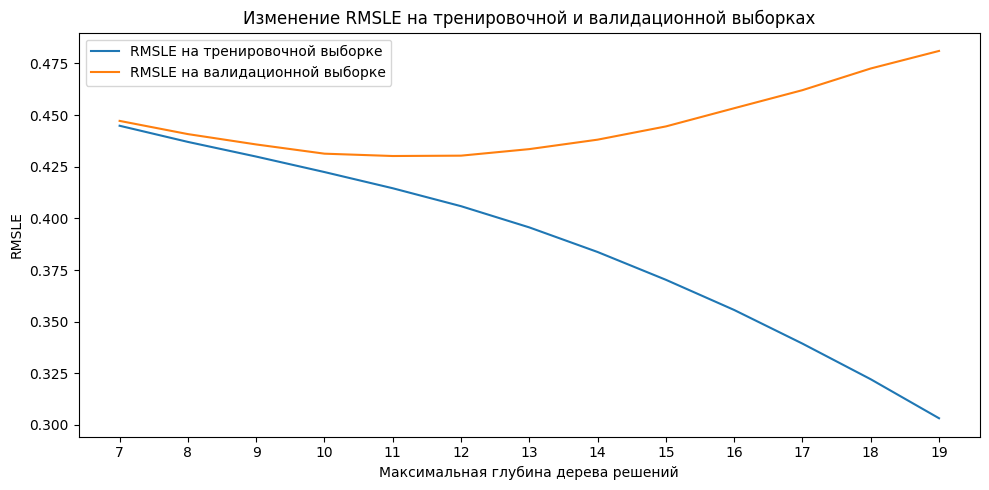

In [61]:
# Строим линейные графики изменения метрики RMSLE
plt.subplots(figsize=(10, 5))
plt.plot(max_depths, train_rmsle, label='RMSLE на тренировочной выборке')
plt.plot(max_depths, valid_rmsle, label='RMSLE на валидационной выборке')
plt.xlabel('Максимальная глубина дерева решений')
plt.ylabel('RMSLE')
plt.title('Изменение RMSLE на тренировочной и валидационной выборках')
plt.xticks(max_depths)
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
# Находим индекс оптимального RMSLE на валидационной выборке
best_index = valid_rmsle.index(min(valid_rmsle))

# Выводим результаты
print('а) Оптимальная максимальная глубина дерева решений: {}'.
      format(max_depths[best_index]))
print('б) RMSLE на тренировочной выборке: {}'.
      format(round(train_rmsle[best_index], 2)))
print('   RMSLE на валидационной выборке: {}'.
      format(round(valid_rmsle[best_index], 2)))

а) Оптимальная максимальная глубина дерева решений: 11
б) RMSLE на тренировочной выборке: 0.41
   RMSLE на валидационной выборке: 0.43


**Т.к. метрики RMSLE на тренировочной и валидационной выборках сопоставимы, то проблема переобучения модели отсутствует.**

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [63]:
# Импортируем класс RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Создаём модель-объект класса RandomForestRegressor
rf_model = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42,
    n_jobs=-1
)

# Обучаем модель на тренировочной выборке
rf_model.fit(X_train, y_train_log)

# Предсказываем значения на тренировочной выборке
y_train_pred = rf_model.predict(X_train)

# Предсказываем значения на валидационной выборке
y_valid_pred = rf_model.predict(X_valid)

In [64]:
# Считаем метрику RMSLE на тренировочной выборке
print('RMSLE на тренировочной выборке: {}'.
      format(round(np.sqrt(metrics.
            mean_squared_error(y_train_log, y_train_pred)), 2)))

# Считаем метрику RMSLE на валидационной выборке
print('RMSLE на валидационной выборке: {}'.
      format(round(np.sqrt(metrics.
            mean_squared_error(y_valid_log, y_valid_pred)), 2)))

RMSLE на тренировочной выборке: 0.4
RMSLE на валидационной выборке: 0.41


**Т.к. метрики RMSLE на тренировочной и валидационной выборках сопоставимы, то проблема переобучения модели отсутствует.**

### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [65]:
# Создаём модель-объект класса GradientBoostingRegressor
gb_model = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42
)

# Обучаем модель на тренировочной выборке
gb_model.fit(X_train, y_train_log)

# Предсказываем значения на тренировочной выборке
y_train_pred = gb_model.predict(X_train)

# Предсказываем значения на валидационной выборке
y_valid_pred = gb_model.predict(X_valid)

In [66]:
# Считаем метрику RMSLE на тренировочной выборке
print('RMSLE на тренировочной выборке: {}'.
      format(round(np.sqrt(metrics.
            mean_squared_error(y_train_log, y_train_pred)), 2)))

# Считаем метрику RMSLE на валидационной выборке
print('RMSLE на валидационной выборке: {}'.
      format(round(np.sqrt(metrics.
            mean_squared_error(y_valid_log, y_valid_pred)), 2)))

RMSLE на тренировочной выборке: 0.37
RMSLE на валидационной выборке: 0.39


**Т.к. метрики RMSLE на тренировочной и валидационной выборках сопоставимы, то проблема переобучения модели отсутствует.**

### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


Наилучший результат показала модель **Градиентный бустинг над деревьями решений**

* Линейная регрессия — 0.54
* Полиномиальная регрессия 2ой степени — 0.48
* Дерево решений — 0.43
* Случайный лес — 0.41
* Градиентный бустинг над деревьями решений — 0.39

### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


In [67]:
# Получаем значимость факторов из модели
feat_importance = gb_model.feature_importances_

# Создаём список факторов
features = X_train.columns

# Сортируем значимость факторов по убыванию
sorted_indices = np.argsort(feat_importance)[::-1]

# Получаем топ-3 фактора
top_3 = features[sorted_indices][:3]

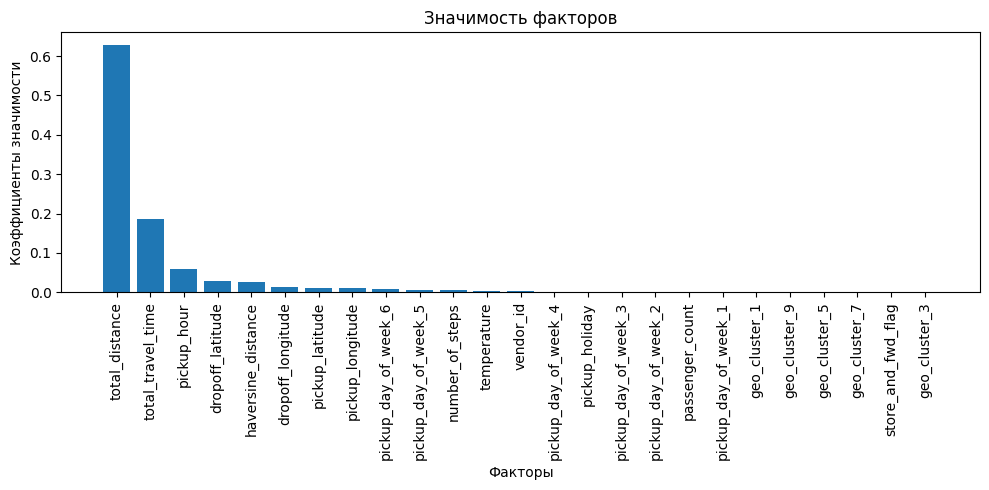

Топ-3 фактора:
  - total_distance
 - total_travel_time
 - pickup_hour


In [68]:
# Строим столбчатую диаграмму
plt.figure(figsize=(10, 5))
plt.bar(range(len(features)), feat_importance[sorted_indices])
plt.xticks(range(len(features)), features[sorted_indices], rotation=90)
plt.xlabel('Факторы')
plt.ylabel('Коэффициенты значимости')
plt.title('Значимость факторов')
plt.tight_layout()
plt.show()

# Выводим топ-3 фактора
print("Топ-3 фактора:\n", '\n'.join(f" - {feature}" for feature in top_3))

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [69]:
# Преобразуем целевую переменную и предсказанные значения
# из логарифмического масштаба в исходный
y_valid = np.exp(y_valid_log) - 1
y_valid_pred_exp = np.exp(y_valid_pred) - 1

# Считаем значения MeAE в минутах
print('MeAE предсказания длительности поездки такси на валидационной выборке: {} мин'.
      format(round(metrics.median_absolute_error(y_valid, y_valid_pred_exp) / 60, 1)))

MeAE предсказания длительности поездки такси на валидационной выборке: 1.8 мин


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [70]:
test_data = pd.read_csv("data/test.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']
test_data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [71]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

c:\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [72]:
# Предсказываем значения целевой переменной на тестовой
# выборке с помощью обученной модели градиентного бустинга
y_test_pred_log = gb_model.predict(X_test_scaled)

# Переводим предсказания из логарифмического маштаба в истинный
y_test_predict = np.exp(y_test_pred_log) - 1

# Cоздаём Submission-файл
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [73]:
#!pip install xgboost

После чего модуль можно импортировать:

In [74]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [75]:
X_train_scaled = X_train
X_valid_scaled = X_valid

In [77]:
# Преобразовываем best_features в список строк
best_features = list(map(str, best_features))
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [78]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.73992	valid-rmse:0.74194
[10]	train-rmse:0.49099	valid-rmse:0.49359
[20]	train-rmse:0.44098	valid-rmse:0.44382
[30]	train-rmse:0.42669	valid-rmse:0.42968
[40]	train-rmse:0.41930	valid-rmse:0.42244
[50]	train-rmse:0.41393	valid-rmse:0.41733
[60]	train-rmse:0.40989	valid-rmse:0.41365
[70]	train-rmse:0.40751	valid-rmse:0.41162
[80]	train-rmse:0.40495	valid-rmse:0.40929
[90]	train-rmse:0.40279	valid-rmse:0.40750
[100]	train-rmse:0.40081	valid-rmse:0.40583
[110]	train-rmse:0.39933	valid-rmse:0.40465
[120]	train-rmse:0.39765	valid-rmse:0.40322
[130]	train-rmse:0.39623	valid-rmse:0.40202
[140]	train-rmse:0.39506	valid-rmse:0.40120
[150]	train-rmse:0.39403	valid-rmse:0.40048
[160]	train-rmse:0.39305	valid-rmse:0.39975
[170]	train-rmse:0.39232	valid-rmse:0.39932
[180]	train-rmse:0.39145	valid-rmse:0.39878
[190]	train-rmse:0.39055	valid-rmse:0.39815
[200]	train-rmse:0.38989	valid-rmse:0.39775
[210]	train-rmse:0.38917	valid-rmse:0.39726
[220]	train-rmse:0.38859	valid-rmse:0.39693

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [79]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39448


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

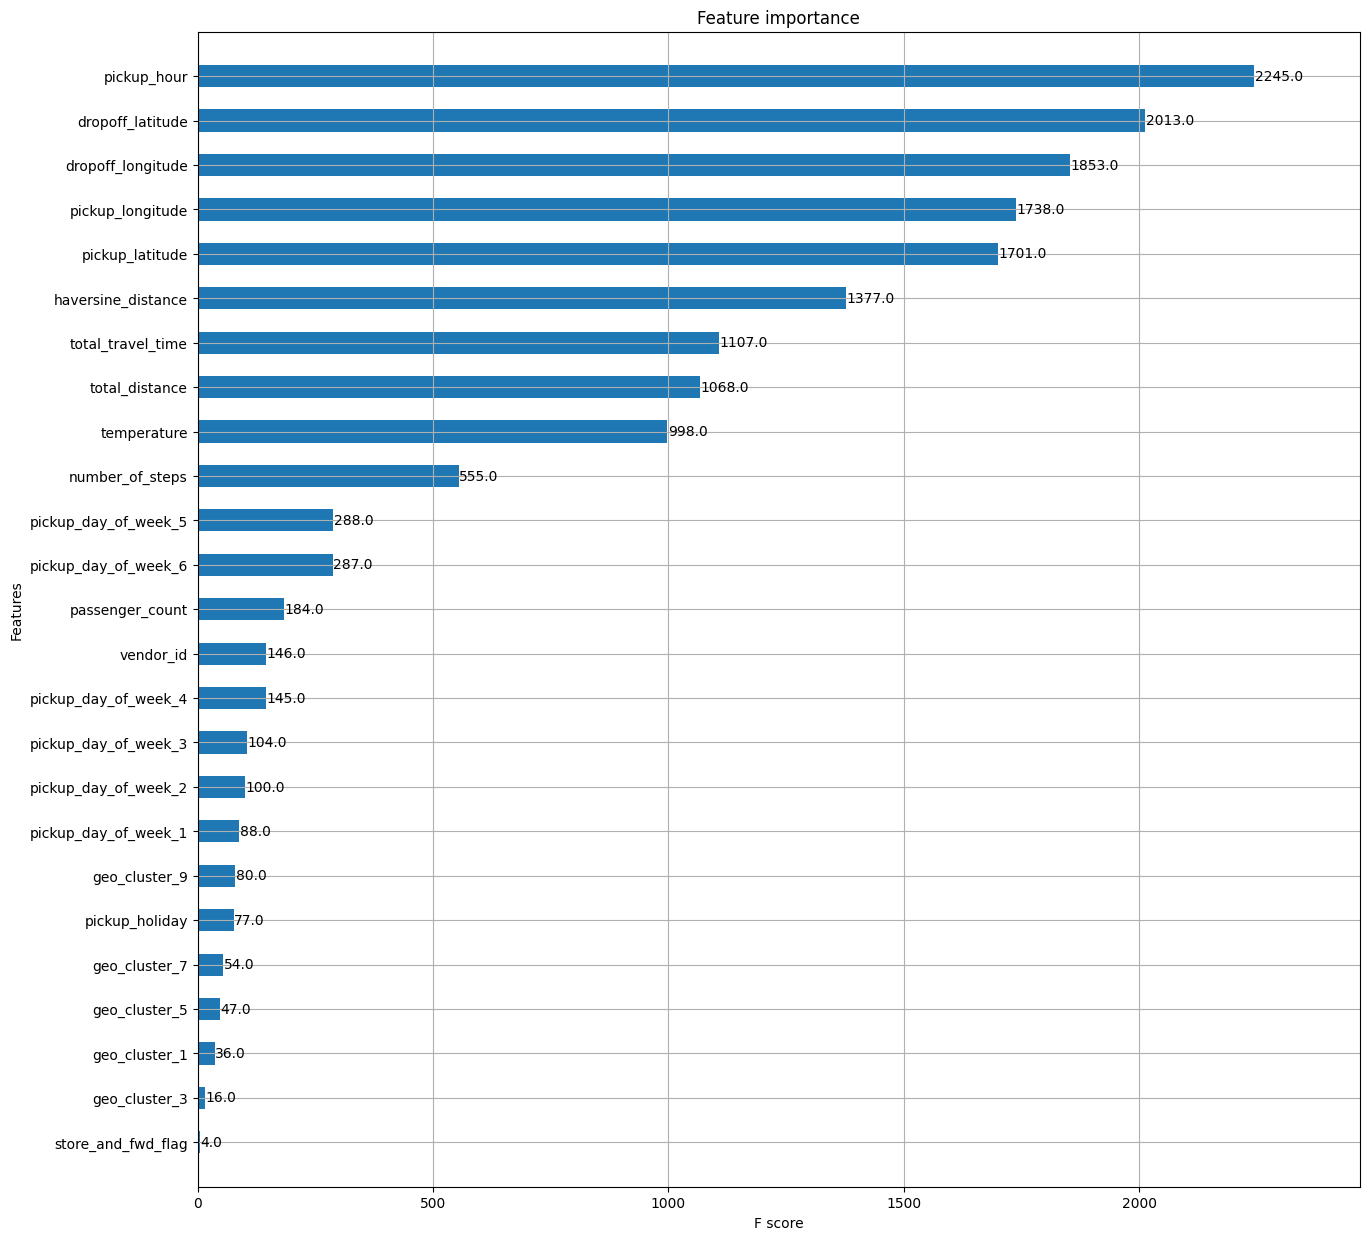

In [80]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)